In [1]:
from siuba import *
import pandas as pd

import matplotlib.cbook

import warnings
import plotnine
warnings.filterwarnings(module='plotnine*', action='ignore')
warnings.filterwarnings(module='matplotlib*', action='ignore')

%matplotlib inline
%load_ext blackcellmagic

In [2]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-07-23/wildlife_impacts.csv",
    parse_dates = ['incident_date']
    )

In [3]:
data.columns

Index(['incident_date', 'state', 'airport_id', 'airport', 'operator', 'atype',
       'type_eng', 'species_id', 'species', 'damage', 'num_engs',
       'incident_month', 'incident_year', 'time_of_day', 'time', 'height',
       'speed', 'phase_of_flt', 'sky', 'precip', 'cost_repairs_infl_adj'],
      dtype='object')

# Incidents over time

*  7.8-fold from 1,850 in 1990 to a record 14,496 in 2017
* In 2017, birds were involved in 95.0 percent of the reported strikes, bats in 2.9 percent, terrestrial mammals in 1.8 percent and reptiles in 0.3 percent. 



In [4]:
data >> summarize(match = (_.incident_date.dt.year == _.incident_year).all())

,match
0,True


##  Number of incidents reported per month

* Increase in incidents later in the year due to more flights going out (need flight data)?

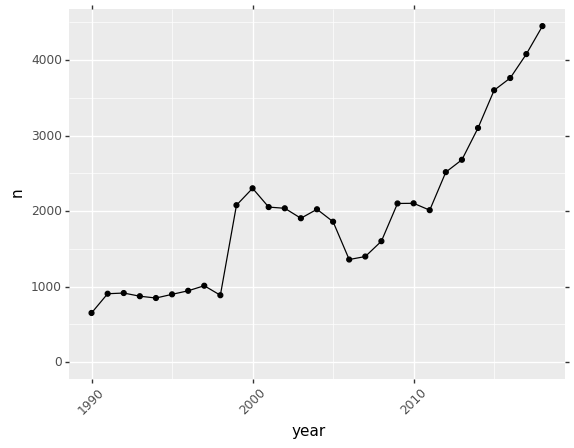

<ggplot: (-9223372036568365431)>

In [5]:
from siuba.dply.vector import n
from plotnine import *

incidents_per_year = (data
  >> group_by(
       year = _.incident_date.dt.year,
#        year = _.incident_date.values.astype('datetime64[M]')
       )
  >> summarize(n = n(_))
  )

(incidents_per_year
#   >> filter(_.year > "2015-01-01")
  >> ggplot(aes('year', 'n')) 
   + geom_point()
   + geom_line()
   + expand_limits(y = 0)
   + theme(axis_text_x=element_text(angle=45))
  )

In [6]:
(incidents_per_year
  >> filter(_.year.isin([1990, 2017]))
  >> summarize(prop=_.n.iloc[1] / _.n.iloc[0])
  )

,prop
0,6.268817


## Birds, bats, terrestrial mammals

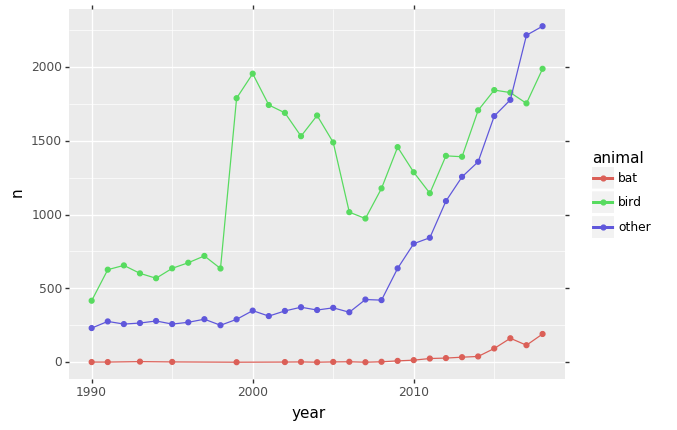

<ggplot: (286439421)>

In [7]:
# in 2017, 
# birds were involved in 95.0 percent of the reported strikes, 
# bats in 2.9 percent, terrestrial
# mammals in 1.8 percent and reptiles in 0.3 percent.
get_animal = case_when({
    _.species.str.contains("bat") : "bat",
    _.species.str.contains("bird") : "bird",
    True: "other"
    })

(data
  >> count(year = _.incident_date.dt.year, animal = get_animal(_))
  >> ggplot(aes('year', 'n', color = 'animal'))
   + geom_point()
   + geom_line()
  )

In [8]:
# it's clear this is missing many of the "others" are birds...
data >> filter(get_animal(_) == "other") >> count(_.species, sort=True) >> head()

,species,n
0,Gulls,1504
1,Mourning dove,1341
2,Barn swallow,1171
3,European starling,848
4,Horned lark,836


# Damaging Incidents

* damaging strikes has declined since 2000
* height of bird strikes
* correlation between body mass and causing damage

Damage: M = minor, M? = uncertain + damaged, S = substantial, D = destroyed

### Decline of damaging strikes since 2000

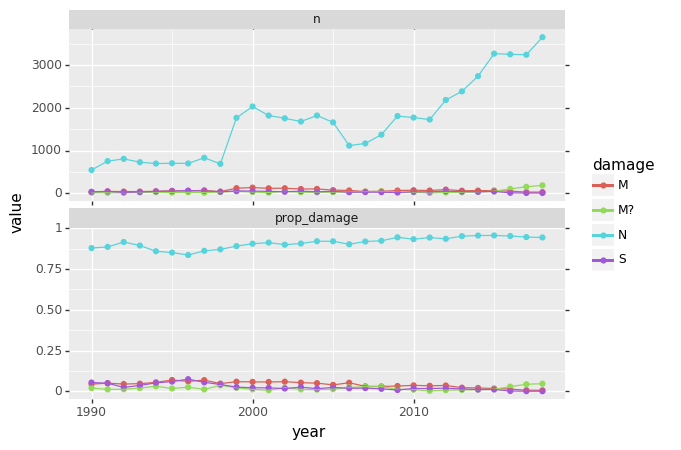

<ggplot: (297935459)>

In [9]:
(data
    >> count(year=_.incident_date.dt.year, damage=_.damage)
    >> group_by(_.year)
    >> mutate(prop_damage = _.n / _.n.sum())
    >> ungroup()
    >> gather("measure", "value", _.prop_damage, _.n)
    >> ggplot(aes("year", "value", color="damage"))
     + geom_point()
     + geom_line()
     + facet_wrap("~ measure", ncol = 1, scales = "free_y")
    )

### Damage is relatively more common above 500 feet

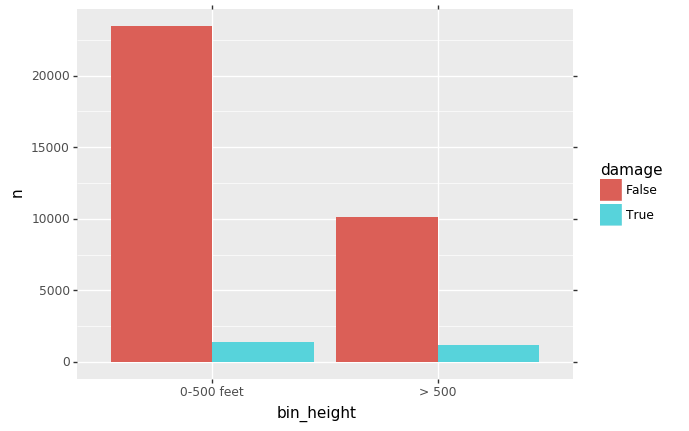

<ggplot: (-9223372036556789637)>

In [10]:
from siuba.dply.forcats import fct_reorder
(data
    >> filter(_.height.notna(), _.damage.notna())
    >> mutate(bin_height = case_when({_.height > 500: "> 500", True: "0-500 feet"}))
    >> count(_.bin_height, damage = _.damage != "N")
    >> ggplot(aes("bin_height", "n", fill = "damage")) + geom_col(position = "dodge")
    )

### Larger body mass associated with damage

In [11]:
# Would need bird mass measure to do this analysis